## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [67]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [68]:
from nndl import Softmax

In [84]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [88]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples
loss = softmax.loss(X_train, y_train)

In [71]:
print(loss)

2.3277607028048757


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

The returned loss matches the value of log(10) for random weights and uniform prediction when there are 10 classes.

#### Softmax gradient

In [101]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 2.945479 analytic: 0.922530, relative error: 5.229948e-01
numerical: -8.841776 analytic: -0.336807, relative error: 9.266103e-01
numerical: 2.815021 analytic: 0.942174, relative error: 4.984696e-01
numerical: -0.881659 analytic: 0.095651, relative error: 1.000000e+00
numerical: -1.303308 analytic: -0.465708, relative error: 4.734836e-01
numerical: -1.465940 analytic: 0.618166, relative error: 1.000000e+00
numerical: 0.031112 analytic: 0.300447, relative error: 8.123300e-01
numerical: -3.721009 analytic: 0.212088, relative error: 1.000000e+00
numerical: -3.406102 analytic: -1.118565, relative error: 5.055701e-01
numerical: -2.380806 analytic: 0.012645, relative error: 1.000000e+00


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [102]:
import time

In [104]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 0.32662109038765486 / 149.34920231801735 computed in 0.049154043197631836s
Vectorized loss / grad: 0.3266210903876548 / 149.34920231801738 computed in 0.00480961799621582s
difference in loss / grad: 5.551115123125783e-17 /1.2690572558103116e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 1.882824529864834
iteration 100 / 1500: loss 1.2437903746477488
iteration 200 / 1500: loss 0.9152666507554195
iteration 300 / 1500: loss 0.853402587728199
iteration 400 / 1500: loss 0.6900934996561776
iteration 500 / 1500: loss 0.4870659465524911
iteration 600 / 1500: loss 0.4186351270118901
iteration 700 / 1500: loss 0.4473496683855273
iteration 800 / 1500: loss 0.5791586121162369
iteration 900 / 1500: loss 0.2911330397567358
iteration 1000 / 1500: loss 0.23253615258882637
iteration 1100 / 1500: loss 0.34362600263720844
iteration 1200 / 1500: loss 0.2787346591064108
iteration 1300 / 1500: loss 0.20159630496015954
iteration 1400 / 1500: loss 0.22733594388376382
That took 8.488666296005249s


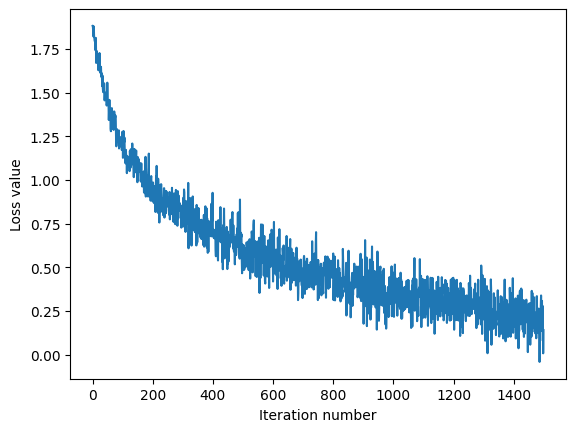

In [105]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [106]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3820612244897959
validation accuracy: 0.393


## Optimize the softmax classifier

In [108]:
np.finfo(float).eps

np.float64(2.220446049250313e-16)

In [ ]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

best_lr = None
best_val_accuracy = 0
learning_rates = [10**i for i in range(-10, 2)]
results = {}

for lr in learning_rates:
    softmax.train(X_train, y_train, learning_rate=lr,
                      num_iters=1500, verbose=False)
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val_pred == y_val)
    results[lr] = val_accuracy

    if val_accuracy > best_val_accuracy:
        best_lr = lr
        best_val_accuracy = val_accuracy

print("Validation Results:")
for lr, accuracy in results.items():
    print(f"Learning rate: {lr}, Validation Accuracy: {accuracy:.4f}")

print("")
print(f"Best learning rate: {best_lr}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #



Validation Results:
Learning rate: 1e-10, Validation Accuracy: 0.0880
Learning rate: 1e-09, Validation Accuracy: 0.1710
Learning rate: 1e-08, Validation Accuracy: 0.2990
Learning rate: 1e-07, Validation Accuracy: 0.3800
Learning rate: 1e-06, Validation Accuracy: 0.4060
Learning rate: 1e-05, Validation Accuracy: 0.2970
Learning rate: 0.0001, Validation Accuracy: 0.3310
Learning rate: 0.001, Validation Accuracy: 0.2480
Learning rate: 0.01, Validation Accuracy: 0.2620
Learning rate: 0.1, Validation Accuracy: 0.2610
Learning rate: 1, Validation Accuracy: 0.2650
Learning rate: 10, Validation Accuracy: 0.2560

Best learning rate: 1e-06
Best validation accuracy: 0.4060
